In [2]:
from nilearn import image
from nilearn.maskers import NiftiMasker
from scipy import stats
from scipy.io import loadmat
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import numpy as np
import nibabel as nib
import pandas as pd
import os,glob
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#load subject matrix
def load_matrix():
    data = loadmat('/Volumes/Cingulate/Sweetspot_Seg/efield_subject_matrix.mat')
    first_matrix = data['first_matrix']
    masker = NiftiMasker(mask_img='/Volumes/Cingulate/Sweetspot_Seg/Outputs/binary/zones1-2/binary_n-map.nii.gz', standardize=True)
    mask_nii = masker.fit()
    return mask_nii, first_matrix

#index matrix and df by cohort
def matrix_df_selection(first_matrix,df_array):
    ranges = [(0, 3), (4, 5), (6, 18), (19, 21), (22, 25), (26, 27), (28, 29), (30, 32), (32, 33), (34, 37), (38, 39), (40, 47)]
    second_matrix,df_selection = first_matrix.copy(),df_array.copy()
    
    #make cohort matricies
    cingulotomy_rows = np.concatenate([np.arange(start, end) for start, end in ranges])
    cingulotomy_matrix = second_matrix[cingulotomy_rows]
    cap_sct_matrix = np.delete(second_matrix,cingulotomy_rows,axis=0)
    
    #make clinical outcomes cohorts
    cingulotomy_df = df_selection[cingulotomy_rows]
    cap_sct_df = np.delete(df_selection,cingulotomy_rows, axis=0)
    
    return cingulotomy_matrix, cap_sct_matrix, cingulotomy_df, cap_sct_df

df = pd.read_csv('/Volumes/Cingulate/Sweetspot_Seg/All_YBOCS_Vol_Cohort.csv')
df_array = df['Relative'].to_numpy().reshape(-1, 1) #change for absolute vs relative

mask_nii, first_matrix = load_matrix()
cingulotomy_matrix, cap_sct_matrix, cingulotomy_df, cap_sct_df = matrix_df_selection(first_matrix,df_array)

In [7]:
def sweetspot(matrix,df):
    #pearson and spearman correlations of matrix and clinical outcomes
    def correlations(A, B,path,export=False):
        n = A.shape[1]
        dist = stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
        pear_r, pear_p, spear_r, spear_p = None, None, None, None
        A[np.isnan(A)],B[np.isnan(B)] = 0,0 #make nans 0
        if corr_type == 'pearson' or corr_type == 'both':
            A_mA = A - A.mean(1)[:, None]
            B_mB = B - B.mean(1)[:, None]
            ssA = (A_mA**2).sum(1)
            ssB = (B_mB**2).sum(1)
            pear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))).ravel()
            pear_p = 2*dist.cdf(-abs(pear_r))
            pear_p = np.around(pear_p, 200)
            pear_r[np.isnan(pear_r)],pear_p[np.isnan(pear_p)] = 0,0 #replace nans with 0s
            pos_pear_r = pear_r.copy()
            pos_pear_r[pos_pear_r < 0] = 0
        if corr_type == 'spearman' or corr_type == 'both':
            rank_A = np.apply_along_axis(lambda x: stats.rankdata(x, method='average'), 1, A) #ranking
            rank_B = np.apply_along_axis(lambda x: stats.rankdata(x, method='average'), 1, B)
            A_mA = rank_A - rank_A.mean(1)[:, None]
            B_mB = rank_B - rank_B.mean(1)[:, None]
            ssA = (A_mA**2).sum(1)
            ssB = (B_mB**2).sum(1)
            spear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))).ravel()
            spear_p = 2 * dist.cdf(-np.abs(spear_r))
            spear_p = np.around(spear_p, 200)
            spear_r[np.isnan(spear_r)],spear_p[np.isnan(spear_p)] = 0,0 #replace nans with 0s
            pos_spear_r = spear_r.copy()
            pos_spear_r[pos_spear_r < 0] = 0
        
        if export:
            if corr_type == 'pearson' or corr_type == 'both':
                nib.save(mask_nii.inverse_transform(pear_r.reshape(1, -1)), f'{path}/pearson_r-map.nii.gz'),nib.save(mask_nii.inverse_transform(pear_p.reshape(1, -1)), f'{path}/pearson_p-map_from_r.nii.gz'),nib.save(mask_nii.inverse_transform(pos_pear_r.reshape(1, -1)), f'{path}/positive_pearson_r-map.nii.gz')
            if corr_type == 'spearman' or corr_type == 'both':
                nib.save(mask_nii.inverse_transform(spear_r.reshape(1, -1)), f'{path}/spearman_r-map.nii.gz'),nib.save(mask_nii.inverse_transform(spear_p.reshape(1, -1)), f'{path}/spearman_p-map_from_r.nii.gz'),nib.save(mask_nii.inverse_transform(pos_spear_r.reshape(1, -1)), f'{path}/positive_spearman_r-map.nii.gz')
        return pear_r,pear_p,pos_pear_r,spear_r,spear_p,pos_spear_r

    #make r and p maps only where significant p < 0.05
    def significant(path, corr_type, pear_r, pear_p, spear_r, spear_p, export=False):
        sig_pearson_r, sig_pearson_p, sig_spearman_r, sig_spearman_p = None, None, None, None
        if corr_type == 'pearson' or corr_type == 'both':
            sig_pearson_r, sig_pearson_p = pear_r.copy(),pear_p.copy()
            sig_pearson_mask = (pear_p > 0) & (pear_p <= 0.05)
            sig_pearson_r[sig_pearson_mask == 0], sig_pearson_p[sig_pearson_mask == 0] = 0,0
            pos_sig_pearson_r = sig_pearson_r.copy()
            pos_sig_pearson_r[sig_pearson_r < 0] = 0
            if export:
                nib.save(mask_nii.inverse_transform(sig_pearson_r.reshape(1, -1)), f'{path}/pearson_sig_r-map.nii.gz'),nib.save(mask_nii.inverse_transform(sig_pearson_p.reshape(1, -1)), f'{path}/pearson_sig_p-map.nii.gz'),nib.save(mask_nii.inverse_transform(pos_sig_pearson_r.reshape(1, -1)), f'{path}/positive_pearson_sig_r-map.nii.gz')
      
        if corr_type == 'spearman' or corr_type == 'both':
            sig_spearman_r, sig_spearman_p = spear_r.copy(),spear_p.copy()
            sig_spearman_mask = (spear_p > 0) & (spear_p <= 0.05)
            sig_spearman_r[sig_spearman_mask == 0], sig_spearman_p[sig_spearman_mask == 0] = 0,0
            pos_sig_spearman_r = sig_spearman_r.copy()
            pos_sig_spearman_r[sig_spearman_r < 0] = 0
            if export:
                nib.save(mask_nii.inverse_transform(sig_spearman_r.reshape(1, -1)), f'{path}/spearman_sig_r-map.nii.gz'),nib.save(mask_nii.inverse_transform(sig_spearman_p.reshape(1, -1)), f'{path}/spearman_sig_p-map.nii.gz'),nib.save(mask_nii.inverse_transform(pos_sig_spearman_r.reshape(1, -1)), f'{path}/positive_spearman_sig_r-map.nii.gz')
        return sig_pearson_r, sig_pearson_p,pos_sig_pearson_r, sig_spearman_r, sig_spearman_p,pos_sig_spearman_r

    #n-map
    def n_map(matrix, path, export=False):
        n_matrix = matrix.copy()
        n_matrix[n_matrix != 0] = 1
        sum_vector = np.sum(n_matrix, axis=0)
        
        #threshold n-map
        thresholded_vector = sum_vector.copy()
        thresholded_vector[thresholded_vector <= threshold] = 0
        
        if export:
            sum_vector_reshape = sum_vector.reshape(1, -1)
            thresholded_vector_reshape = thresholded_vector.reshape(1, -1)
            nib.save(mask_nii.inverse_transform(sum_vector_reshape[0]), f'{path}/n-map.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_vector_reshape[0]), f'{path}/n-map_thresholded_by_{threshold}.nii.gz')
        return thresholded_vector

    #threshold r-maps to designated threshold of n-map
    def threshold_r_p(thresholded_vector, path, threshold, pear_r, pear_p, sig_pearson_r, sig_pearson_p, spear_r, spear_p, sig_spearman_r, sig_spearman_p, corr_type, export):
        binary_threshold_n_vector = thresholded_vector.copy()
        binary_threshold_n_vector[binary_threshold_n_vector > 0] = 1
        if corr_type == 'pearson' or corr_type == 'both':
            thresholded_pearson_sig_r, thresholded_pearson_r = sig_pearson_r.copy(), pear_r.copy()
            thresholded_pearson_sig_p, thresholded_pearson_p = sig_pearson_p.copy(), pear_p.copy()
            thresholded_pearson_sig_r[binary_threshold_n_vector == 0],thresholded_pearson_r[binary_threshold_n_vector == 0] = 0,0
            thresholded_pearson_sig_p[binary_threshold_n_vector == 0],thresholded_pearson_p[binary_threshold_n_vector == 0] = 0,0
            
            pos_thresholded_pearson_r,pos_thresholded_pearson_sig_r = thresholded_pearson_r.copy(),thresholded_pearson_sig_r.copy()
            pos_thresholded_pearson_r[pos_thresholded_pearson_r < 0] = 0 #make all neg values = 0
            pos_thresholded_pearson_sig_r[pos_thresholded_pearson_sig_r < 0] = 0 #make all neg values = 0
            if export:
                nib.save(mask_nii.inverse_transform(thresholded_pearson_sig_r.reshape(1, -1)), f'{path}/sig_pearson_r-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_pearson_sig_p.reshape(1, -1)), f'{path}/sig_pearson_p-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_pearson_r.reshape(1, -1)), f'{path}/pearson_r-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_pearson_p.reshape(1, -1)), f'{path}/pearson_p-map_thresholded_by_{threshold}.nii.gz'),nib.save(mask_nii.inverse_transform(pos_thresholded_pearson_sig_r.reshape(1, -1)), f'{path}/positive_sig_pearson_r-map_thresholded_by_{threshold}.nii.gz')
       
        if corr_type == 'spearman' or corr_type == 'both':
            thresholded_spearman_sig_r, thresholded_spearman_r = sig_spearman_r.copy(), spear_r.copy()
            thresholded_spearman_sig_p, thresholded_spearman_p = sig_spearman_p.copy(), spear_p.copy()
            thresholded_spearman_sig_r[binary_threshold_n_vector == 0],thresholded_spearman_r[binary_threshold_n_vector == 0] = 0,0
            thresholded_spearman_sig_p[binary_threshold_n_vector == 0],thresholded_spearman_p[binary_threshold_n_vector == 0] = 0,0
            
            pos_thresholded_spearman_r,pos_thresholded_spearman_sig_r = thresholded_spearman_r.copy(),thresholded_spearman_sig_r.copy()
            pos_thresholded_spearman_r[pos_thresholded_spearman_r < 0] = 0 #make all neg values = 0
            pos_thresholded_spearman_sig_r[pos_thresholded_spearman_sig_r < 0] = 0 #make all neg values = 0
            if export:
                nib.save(mask_nii.inverse_transform(thresholded_spearman_sig_r.reshape(1, -1)), f'{path}/sig_spearman_r-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_spearman_sig_p.reshape(1, -1)), f'{path}/sig_spearman_p-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_spearman_r.reshape(1, -1)), f'{path}/spearman_r-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_spearman_p.reshape(1, -1)), f'{path}/spearman_p-map_thresholded_by_{threshold}.nii.gz'),nib.save(mask_nii.inverse_transform(pos_thresholded_spearman_sig_r.reshape(1, -1)), f'{path}/positive_spearman_r-map_thresholded_by_{threshold}.nii.gz')
        return thresholded_pearson_r, thresholded_pearson_sig_r, thresholded_pearson_p, thresholded_pearson_sig_p, thresholded_spearman_r, thresholded_spearman_sig_r, thresholded_spearman_p, thresholded_spearman_sig_p,pos_thresholded_pearson_r,pos_thresholded_pearson_sig_r,pos_thresholded_spearman_r,pos_thresholded_spearman_sig_r

    path = '/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests' #path to export to
    export = False
    threshold = 5 #n-threshold, greater than or equal to

    matrix = cingulotomy_matrix #cingulotomy_matrix or cap_sct_matrix
    df = cingulotomy_df #cingulotomy_df or cap_sct_df
    
    pearson_r, pearson_p, pos_pearson_r, spearman_r, spearman_p, pos_spearman_r = correlations(matrix.T, df.T, path, export)
    sig_pearson_r, sig_pearson_p, pos_sig_pearson_r, sig_spearman_r, sig_spearman_p,pos_sig_spearman_r = significant(path, corr_type, pearson_r, pearson_p, spearman_r, spearman_p, export)
    thresholded_n_result = n_map(matrix, path, export)
    thresholded_pearson_r, thresholded_pearson_sig_r, thresholded_pearson_p, thresholded_pearson_sig_p,pos_thresholded_pearson_r,pos_thresholded_pearson_sig_r, thresholded_spearman_r, thresholded_spearman_sig_r, thresholded_spearman_p, thresholded_spearman_sig_p,pos_thresholded_spearman_r,pos_thresholded_spearman_sig_r = threshold_r_p(thresholded_n_result, path, threshold, pearson_r, pearson_p, sig_pearson_r, sig_pearson_p, spearman_r, spearman_p, sig_spearman_r, sig_spearman_p, corr_type, export)

    return pearson_r,pos_pearson_r,sig_pearson_r,pos_sig_pearson_r,spearman_r,pos_spearman_r, sig_spearman_r, pos_sig_spearman_r,thresholded_pearson_r,thresholded_pearson_sig_r, pos_thresholded_pearson_r,pos_thresholded_pearson_sig_r, thresholded_spearman_r, thresholded_spearman_sig_r,pos_thresholded_spearman_r,pos_thresholded_spearman_sig_r

#get overlap and r & p values
def sweetspot_score(corr_type,matrix,df_column,pearson_r,pos_pearson_r,sig_pearson_r,pos_sig_pearson_r,spearman_r,pos_spearman_r, sig_spearman_r, pos_sig_spearman_r,thresholded_pearson_r, pos_thresholded_pearson_r,thresholded_pearson_sig_r,pos_thresholded_pearson_sig_r, thresholded_spearman_r, thresholded_spearman_sig_r,pos_thresholded_spearman_r,pos_thresholded_spearman_sig_r):
    efield_matrix = matrix.copy()
    #make empty matricies to store outputs in
    pearson_sweetspot_score,pos_pearson_sweetspot_score,sig_pearson_sweetspot_score,pos_sig_pearson_sweetspot_score,thresholded_pearson_sweetspot_score,pos_thresholded_pearson_sweetspot_score,thresholded_sig_pearson_sweetspot_score,pos_thresholded_sig_pearson_sweetspot_score = np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0]))
    spearman_sweetspot_score,sig_spearman_sweetspot_score,thresholded_spearman_sweetspot_score,thresholded_sig_spearman_sweetspot_score,pos_spearman_sweetspot_score,pos_sig_spearman_sweetspot_score,pos_thresholded_spearman_sweetspot_score,pos_thresholded_sig_spearman_sweetspot_score = np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0])
    
    #overall r and p values
    def overall_corr(sweetspot_score,df_column):
        pearson_r, pearson_p = pearsonr(sweetspot_score,df_column)
        spearman_r, spearman_p = spearmanr(sweetspot_score,df_column)
        return pearson_r,pearson_p,spearman_r,spearman_p
    
    if corr_type == 'pearson' or corr_type == 'both':
        for i in range(efield_matrix.shape[0]):
            #multiply voxels together in subject efield and r-map and then average the row together            
            pearson_sweetspot_score[i],pos_pearson_sweetspot_score[i],sig_pearson_sweetspot_score[i],pos_sig_pearson_sweetspot_score[i],thresholded_pearson_sweetspot_score[i],pos_thresholded_pearson_sweetspot_score[i],thresholded_sig_pearson_sweetspot_score[i],pos_thresholded_sig_pearson_sweetspot_score[i] = np.mean(np.multiply(pearson_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(pos_pearson_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(sig_pearson_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(pos_sig_pearson_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(thresholded_pearson_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(pos_thresholded_pearson_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(thresholded_pearson_sig_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(pos_thresholded_pearson_sig_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
        
        pearson_r_val,pearson_p_val,s_pearson_r_val,s_pearson_p_val = overall_corr(pearson_sweetspot_score,df_column)
        sig_pearson_r_val,sig_pearson_p_val,s_sig_pearson_r_val,s_sig_pearson_p_val = overall_corr(sig_pearson_sweetspot_score,df_column)
        thresholded_pearson_r_val,thresholded_pearson_p_val,s_thresholded_pearson_r_val,s_thresholded_pearson_p_val = overall_corr(thresholded_pearson_sweetspot_score,df_column)       
        thresholded_sig_pearson_r_val,thresholded_sig_pearson_p_val,s_thresholded_sig_pearson_r_val,s_thresholded_sig_pearson_p_val = overall_corr(thresholded_sig_pearson_sweetspot_score,df_column)       
        
        pos_pearson_r_val,pos_pearson_p_val,pos_s_pearson_r_val,pos_s_pearson_p_val = overall_corr(pos_pearson_sweetspot_score,df_column)
        pos_sig_pearson_r_val,pos_sig_pearson_p_val,pos_s_sig_pearson_r_val,pos_s_sig_pearson_p_val = overall_corr(pos_sig_pearson_sweetspot_score,df_column)
        pos_thresholded_pearson_r_val,pos_thresholded_pearson_p_val,pos_s_thresholded_pearson_r_val,pos_s_thresholded_pearson_p_val = overall_corr(pos_thresholded_pearson_sweetspot_score,df_column)       
        pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val,pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val = overall_corr(pos_thresholded_sig_pearson_sweetspot_score,df_column)       
        
    if corr_type == 'spearman' or corr_type == 'both':
        for i in range(efield_matrix.shape[0]): 
            #multiply voxels together in subject efield and r-map and then average the row together            
            spearman_sweetspot_score[i] = np.mean(np.multiply(spearman_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
            pos_spearman_sweetspot_score[i] = np.mean(np.multiply(pos_spearman_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
            sig_spearman_sweetspot_score[i] = np.mean(np.multiply(sig_spearman_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
            pos_sig_spearman_sweetspot_score[i] = np.mean(np.multiply(pos_sig_spearman_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
            
            thresholded_spearman_sweetspot_score[i] = np.mean(np.multiply(thresholded_spearman_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
            pos_thresholded_spearman_sweetspot_score[i] = np.mean(np.multiply(pos_thresholded_spearman_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
            
            thresholded_sig_spearman_sweetspot_score[i] = np.mean(np.multiply(thresholded_spearman_sig_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
            pos_thresholded_sig_spearman_sweetspot_score[i] = np.mean(np.multiply(pos_thresholded_spearman_sig_r[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
                        
        p_spearman_r_val,p_spearman_p_val,spearman_r_val,spearman_p_val = overall_corr(spearman_sweetspot_score,df_column)
        p_sig_spearman_r_val,p_sig_spearman_p_val, sig_spearman_r_val,sig_spearman_p_val = overall_corr(sig_spearman_sweetspot_score,df_column)
        p_thresholded_spearman_r_val,p_thresholded_spearman_p_val, thresholded_spearman_r_val,thresholded_spearman_p_val = overall_corr(thresholded_spearman_sweetspot_score,df_column)       
        p_thresholded_sig_spearman_r_val,p_thresholded_sig_spearman_p_val, thresholded_sig_spearman_r_val,thresholded_sig_spearman_p_val = overall_corr(thresholded_sig_spearman_sweetspot_score,df_column)       
        
        pos_p_spearman_r_val,pos_p_spearman_p_val, pos_spearman_r_val,pos_spearman_p_val = overall_corr(pos_spearman_sweetspot_score,df_column)
        pos_p_sig_spearman_r_val,pos_p_sig_spearman_p_val, pos_sig_spearman_r_val,pos_sig_spearman_p_val = overall_corr(pos_sig_spearman_sweetspot_score,df_column)
        pos_p_thresholded_spearman_r_val,pos_p_thresholded_spearman_p_val, pos_thresholded_spearman_r_val,pos_thresholded_spearman_p_val = overall_corr(pos_thresholded_spearman_sweetspot_score,df_column)       
        pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val, pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val = overall_corr(pos_thresholded_sig_spearman_sweetspot_score,df_column)       
    
    return pearson_sweetspot_score,sig_pearson_sweetspot_score,thresholded_pearson_sweetspot_score,thresholded_sig_pearson_sweetspot_score, pos_pearson_sweetspot_score,pos_sig_pearson_sweetspot_score,pos_thresholded_pearson_sweetspot_score,pos_thresholded_sig_pearson_sweetspot_score,spearman_sweetspot_score,sig_spearman_sweetspot_score,thresholded_spearman_sweetspot_score,thresholded_sig_spearman_sweetspot_score,pos_spearman_sweetspot_score,pos_sig_spearman_sweetspot_score,pos_thresholded_spearman_sweetspot_score,pos_thresholded_sig_spearman_sweetspot_score,pearson_r_val,pearson_p_val,sig_pearson_r_val,sig_pearson_p_val,thresholded_pearson_r_val,thresholded_pearson_p_val,thresholded_sig_pearson_r_val,thresholded_sig_pearson_p_val,s_pearson_r_val,s_pearson_p_val,s_sig_pearson_r_val,s_sig_pearson_p_val,s_thresholded_pearson_r_val,s_thresholded_pearson_p_val,s_thresholded_sig_pearson_r_val,s_thresholded_sig_pearson_p_val,spearman_r_val,spearman_p_val,sig_spearman_r_val,sig_spearman_p_val,thresholded_spearman_r_val,thresholded_spearman_p_val,thresholded_sig_spearman_r_val,thresholded_sig_spearman_p_val,p_spearman_r_val,p_spearman_p_val,p_sig_spearman_r_val,p_sig_spearman_p_val,p_thresholded_spearman_r_val,p_thresholded_spearman_p_val,p_thresholded_sig_spearman_r_val,p_thresholded_sig_spearman_p_val,pos_pearson_r_val,pos_pearson_p_val,pos_sig_pearson_r_val,pos_sig_pearson_p_val,pos_thresholded_pearson_r_val,pos_thresholded_pearson_p_val,pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val,pos_s_pearson_r_val,pos_s_pearson_p_val,pos_s_sig_pearson_r_val,pos_s_sig_pearson_p_val,pos_s_thresholded_pearson_r_val,pos_s_thresholded_pearson_p_val,pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val,pos_spearman_r_val,pos_spearman_p_val,pos_sig_spearman_r_val,pos_sig_spearman_p_val,pos_thresholded_spearman_r_val,pos_thresholded_spearman_p_val,pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val,pos_p_spearman_r_val,pos_p_spearman_p_val,pos_p_sig_spearman_r_val,pos_p_sig_spearman_p_val,pos_p_thresholded_spearman_r_val,pos_p_thresholded_spearman_p_val,pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val

df_column = cingulotomy_df.flatten()

def cross_validations(matrix,df):
    num_sub = matrix.shape[0]
    for i in range(num_sub):
        print(f'Iteration: {i + 1}/{num_sub}')
        current_subject_matrix = np.delete(matrix, i, axis=0) #exclude the i-th subject
        current_clinical_outcomes = np.delete(df, i, axis=0) #exclude i-th subject's clinical outcomes
        outputs = sweetspot(current_subject_matrix,current_clinical_outcomes) #call sweetspot function with the modified subject matrix
        #unpack outputs for the sweetspot_score function
        pearson_r,pos_pearson_r,sig_pearson_r,pos_sig_pearson_r,spearman_r,pos_spearman_r, sig_spearman_r, pos_sig_spearman_r,thresholded_pearson_r, thresholded_pearson_sig_r,pos_thresholded_pearson_r,pos_thresholded_pearson_sig_r, thresholded_spearman_r, thresholded_spearman_sig_r,pos_thresholded_spearman_r,pos_thresholded_spearman_sig_r = outputs
        #call sweetspot_score with the obtained outputs
        pearson_sweetspot_score,sig_pearson_sweetspot_score,thresholded_pearson_sweetspot_score,thresholded_sig_pearson_sweetspot_score, pos_pearson_sweetspot_score,pos_sig_pearson_sweetspot_score,pos_thresholded_pearson_sweetspot_score,pos_thresholded_sig_pearson_sweetspot_score,spearman_sweetspot_score,sig_spearman_sweetspot_score,thresholded_spearman_sweetspot_score,thresholded_sig_spearman_sweetspot_score,pos_spearman_sweetspot_score,pos_sig_spearman_sweetspot_score,pos_thresholded_spearman_sweetspot_score,pos_thresholded_sig_spearman_sweetspot_score,pearson_r_val,pearson_p_val,sig_pearson_r_val,sig_pearson_p_val,thresholded_pearson_r_val,thresholded_pearson_p_val,thresholded_sig_pearson_r_val,thresholded_sig_pearson_p_val,s_pearson_r_val,s_pearson_p_val,s_sig_pearson_r_val,s_sig_pearson_p_val,s_thresholded_pearson_r_val,s_thresholded_pearson_p_val,s_thresholded_sig_pearson_r_val,s_thresholded_sig_pearson_p_val,spearman_r_val,spearman_p_val,sig_spearman_r_val,sig_spearman_p_val,thresholded_spearman_r_val,thresholded_spearman_p_val,thresholded_sig_spearman_r_val,thresholded_sig_spearman_p_val,p_spearman_r_val,p_spearman_p_val,p_sig_spearman_r_val,p_sig_spearman_p_val,p_thresholded_spearman_r_val,p_thresholded_spearman_p_val,p_thresholded_sig_spearman_r_val,p_thresholded_sig_spearman_p_val,pos_pearson_r_val,pos_pearson_p_val,pos_sig_pearson_r_val,pos_sig_pearson_p_val,pos_thresholded_pearson_r_val,pos_thresholded_pearson_p_val,pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val,pos_s_pearson_r_val,pos_s_pearson_p_val,pos_s_sig_pearson_r_val,pos_s_sig_pearson_p_val,pos_s_thresholded_pearson_r_val,pos_s_thresholded_pearson_p_val,pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val,pos_spearman_r_val,pos_spearman_p_val,pos_sig_spearman_r_val,pos_sig_spearman_p_val,pos_thresholded_spearman_r_val,pos_thresholded_spearman_p_val,pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val,pos_p_spearman_r_val,pos_p_spearman_p_val,pos_p_sig_spearman_r_val,pos_p_sig_spearman_p_val,pos_p_thresholded_spearman_r_val,pos_p_thresholded_spearman_p_val,pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val = sweetspot_score(corr_type,matrix,df_column,pearson_r,pos_pearson_r,sig_pearson_r,pos_sig_pearson_r,spearman_r,pos_spearman_r, sig_spearman_r, pos_sig_spearman_r,thresholded_pearson_r, pos_thresholded_pearson_r,thresholded_pearson_sig_r,pos_thresholded_pearson_sig_r, thresholded_spearman_r, thresholded_spearman_sig_r,pos_thresholded_spearman_r,pos_thresholded_spearman_sig_r)
    return (pearson_sweetspot_score,sig_pearson_sweetspot_score,thresholded_pearson_sweetspot_score,thresholded_sig_pearson_sweetspot_score, pos_pearson_sweetspot_score,pos_sig_pearson_sweetspot_score,pos_thresholded_pearson_sweetspot_score,pos_thresholded_sig_pearson_sweetspot_score,spearman_sweetspot_score,sig_spearman_sweetspot_score,thresholded_spearman_sweetspot_score,thresholded_sig_spearman_sweetspot_score,pos_spearman_sweetspot_score,pos_sig_spearman_sweetspot_score,pos_thresholded_spearman_sweetspot_score,pos_thresholded_sig_spearman_sweetspot_score,pearson_r_val,pearson_p_val,sig_pearson_r_val,sig_pearson_p_val,thresholded_pearson_r_val,thresholded_pearson_p_val,thresholded_sig_pearson_r_val,thresholded_sig_pearson_p_val,s_pearson_r_val,s_pearson_p_val,s_sig_pearson_r_val,s_sig_pearson_p_val,s_thresholded_pearson_r_val,s_thresholded_pearson_p_val,s_thresholded_sig_pearson_r_val,s_thresholded_sig_pearson_p_val,spearman_r_val,spearman_p_val,sig_spearman_r_val,sig_spearman_p_val,thresholded_spearman_r_val,thresholded_spearman_p_val,thresholded_sig_spearman_r_val,thresholded_sig_spearman_p_val,p_spearman_r_val,p_spearman_p_val,p_sig_spearman_r_val,p_sig_spearman_p_val,p_thresholded_spearman_r_val,p_thresholded_spearman_p_val,p_thresholded_sig_spearman_r_val,p_thresholded_sig_spearman_p_val,pos_pearson_r_val,pos_pearson_p_val,pos_sig_pearson_r_val,pos_sig_pearson_p_val,pos_thresholded_pearson_r_val,pos_thresholded_pearson_p_val,pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val,pos_s_pearson_r_val,pos_s_pearson_p_val,pos_s_sig_pearson_r_val,pos_s_sig_pearson_p_val,pos_s_thresholded_pearson_r_val,pos_s_thresholded_pearson_p_val,pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val,pos_spearman_r_val,pos_spearman_p_val,pos_sig_spearman_r_val,pos_sig_spearman_p_val,pos_thresholded_spearman_r_val,pos_thresholded_spearman_p_val,pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val,pos_p_spearman_r_val,pos_p_spearman_p_val,pos_p_sig_spearman_r_val,pos_p_sig_spearman_p_val,pos_p_thresholded_spearman_r_val,pos_p_thresholded_spearman_p_val,pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val)

matrix = cingulotomy_matrix #cingulotomy_matrix or cap_sct_matrix
corr_type = 'both' #change for pearson or spearman

(pearson_r,pos_pearson_r,sig_pearson_r,pos_sig_pearson_r,spearman_r,pos_spearman_r, sig_spearman_r, pos_sig_spearman_r,thresholded_pearson_r, thresholded_pearson_sig_r,pos_thresholded_pearson_r,pos_thresholded_pearson_sig_r, thresholded_spearman_r, thresholded_spearman_sig_r,pos_thresholded_spearman_r,pos_thresholded_spearman_sig_r) = sweetspot(matrix,df)
(pearson_sweetspot_score,sig_pearson_sweetspot_score,thresholded_pearson_sweetspot_score,thresholded_sig_pearson_sweetspot_score, pos_pearson_sweetspot_score,pos_sig_pearson_sweetspot_score,pos_thresholded_pearson_sweetspot_score,pos_thresholded_sig_pearson_sweetspot_score,spearman_sweetspot_score,sig_spearman_sweetspot_score,thresholded_spearman_sweetspot_score,thresholded_sig_spearman_sweetspot_score,pos_spearman_sweetspot_score,pos_sig_spearman_sweetspot_score,pos_thresholded_spearman_sweetspot_score,pos_thresholded_sig_spearman_sweetspot_score,pearson_r_val,pearson_p_val,sig_pearson_r_val,sig_pearson_p_val,thresholded_pearson_r_val,thresholded_pearson_p_val,thresholded_sig_pearson_r_val,thresholded_sig_pearson_p_val,s_pearson_r_val,s_pearson_p_val,s_sig_pearson_r_val,s_sig_pearson_p_val,s_thresholded_pearson_r_val,s_thresholded_pearson_p_val,s_thresholded_sig_pearson_r_val,s_thresholded_sig_pearson_p_val,spearman_r_val,spearman_p_val,sig_spearman_r_val,sig_spearman_p_val,thresholded_spearman_r_val,thresholded_spearman_p_val,thresholded_sig_spearman_r_val,thresholded_sig_spearman_p_val,p_spearman_r_val,p_spearman_p_val,p_sig_spearman_r_val,p_sig_spearman_p_val,p_thresholded_spearman_r_val,p_thresholded_spearman_p_val,p_thresholded_sig_spearman_r_val,p_thresholded_sig_spearman_p_val,pos_pearson_r_val,pos_pearson_p_val,pos_sig_pearson_r_val,pos_sig_pearson_p_val,pos_thresholded_pearson_r_val,pos_thresholded_pearson_p_val,pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val,pos_s_pearson_r_val,pos_s_pearson_p_val,pos_s_sig_pearson_r_val,pos_s_sig_pearson_p_val,pos_s_thresholded_pearson_r_val,pos_s_thresholded_pearson_p_val,pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val,pos_spearman_r_val,pos_spearman_p_val,pos_sig_spearman_r_val,pos_sig_spearman_p_val,pos_thresholded_spearman_r_val,pos_thresholded_spearman_p_val,pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val,pos_p_spearman_r_val,pos_p_spearman_p_val,pos_p_sig_spearman_r_val,pos_p_sig_spearman_p_val,pos_p_thresholded_spearman_r_val,pos_p_thresholded_spearman_p_val,pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val) = sweetspot_score(corr_type,matrix,df_column,pearson_r,pos_pearson_r,sig_pearson_r,pos_sig_pearson_r,spearman_r,pos_spearman_r, sig_spearman_r, pos_sig_spearman_r,thresholded_pearson_r, pos_thresholded_pearson_r,thresholded_pearson_sig_r,pos_thresholded_pearson_sig_r, thresholded_spearman_r, thresholded_spearman_sig_r,pos_thresholded_spearman_r,pos_thresholded_spearman_sig_r)
(pearson_sweetspot_score,sig_pearson_sweetspot_score,thresholded_pearson_sweetspot_score,thresholded_sig_pearson_sweetspot_score, pos_pearson_sweetspot_score,pos_sig_pearson_sweetspot_score,pos_thresholded_pearson_sweetspot_score,pos_thresholded_sig_pearson_sweetspot_score,spearman_sweetspot_score,sig_spearman_sweetspot_score,thresholded_spearman_sweetspot_score,thresholded_sig_spearman_sweetspot_score,pos_spearman_sweetspot_score,pos_sig_spearman_sweetspot_score,pos_thresholded_spearman_sweetspot_score,pos_thresholded_sig_spearman_sweetspot_score,pearson_r_val,pearson_p_val,sig_pearson_r_val,sig_pearson_p_val,thresholded_pearson_r_val,thresholded_pearson_p_val,thresholded_sig_pearson_r_val,thresholded_sig_pearson_p_val,s_pearson_r_val,s_pearson_p_val,s_sig_pearson_r_val,s_sig_pearson_p_val,s_thresholded_pearson_r_val,s_thresholded_pearson_p_val,s_thresholded_sig_pearson_r_val,s_thresholded_sig_pearson_p_val,spearman_r_val,spearman_p_val,sig_spearman_r_val,sig_spearman_p_val,thresholded_spearman_r_val,thresholded_spearman_p_val,thresholded_sig_spearman_r_val,thresholded_sig_spearman_p_val,p_spearman_r_val,p_spearman_p_val,p_sig_spearman_r_val,p_sig_spearman_p_val,p_thresholded_spearman_r_val,p_thresholded_spearman_p_val,p_thresholded_sig_spearman_r_val,p_thresholded_sig_spearman_p_val,pos_pearson_r_val,pos_pearson_p_val,pos_sig_pearson_r_val,pos_sig_pearson_p_val,pos_thresholded_pearson_r_val,pos_thresholded_pearson_p_val,pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val,pos_s_pearson_r_val,pos_s_pearson_p_val,pos_s_sig_pearson_r_val,pos_s_sig_pearson_p_val,pos_s_thresholded_pearson_r_val,pos_s_thresholded_pearson_p_val,pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val,pos_spearman_r_val,pos_spearman_p_val,pos_sig_spearman_r_val,pos_sig_spearman_p_val,pos_thresholded_spearman_r_val,pos_thresholded_spearman_p_val,pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val,pos_p_spearman_r_val,pos_p_spearman_p_val,pos_p_sig_spearman_r_val,pos_p_sig_spearman_p_val,pos_p_thresholded_spearman_r_val,pos_p_thresholded_spearman_p_val,pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val) = cross_validations(matrix,df_column)

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_4386/952117909.py:13: RuntimeWarning: invalid value encountered in divide
  pear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))).ravel()
/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_4386/952117909.py:26: RuntimeWarning: invalid value encountered in divide
  spear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))).ravel()


Iteration: 1/37
Iteration: 2/37
Iteration: 3/37
Iteration: 4/37
Iteration: 5/37
Iteration: 6/37
Iteration: 7/37
Iteration: 8/37
Iteration: 9/37
Iteration: 10/37
Iteration: 11/37
Iteration: 12/37
Iteration: 13/37
Iteration: 14/37
Iteration: 15/37
Iteration: 16/37
Iteration: 17/37
Iteration: 18/37
Iteration: 19/37
Iteration: 20/37
Iteration: 21/37
Iteration: 22/37
Iteration: 23/37
Iteration: 24/37
Iteration: 25/37
Iteration: 26/37
Iteration: 27/37
Iteration: 28/37
Iteration: 29/37
Iteration: 30/37
Iteration: 31/37
Iteration: 32/37
Iteration: 33/37
Iteration: 34/37
Iteration: 35/37
Iteration: 36/37
Iteration: 37/37


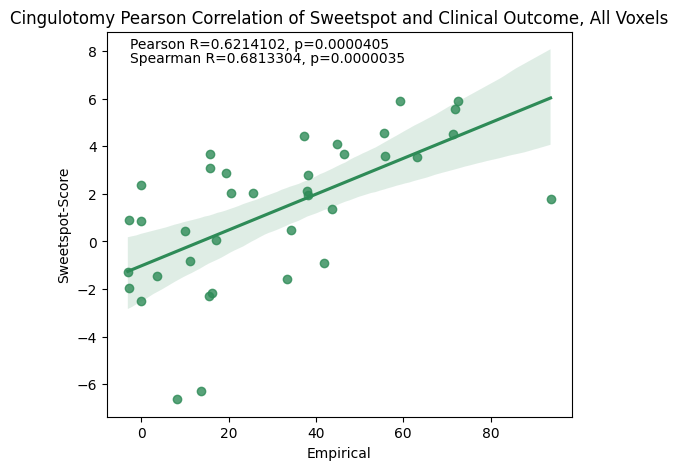

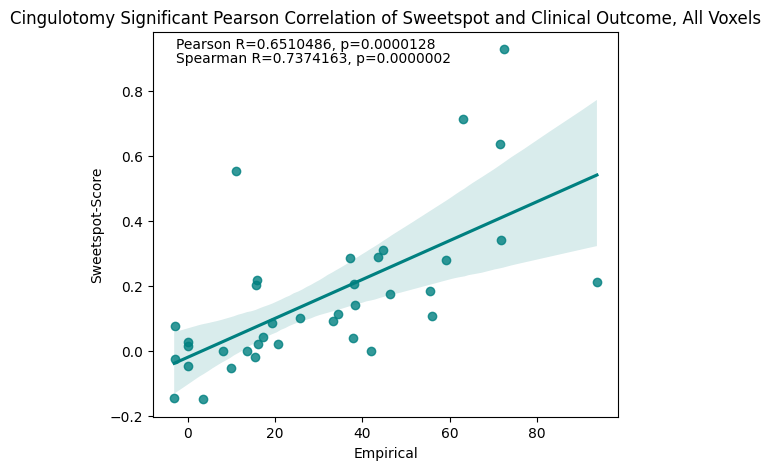

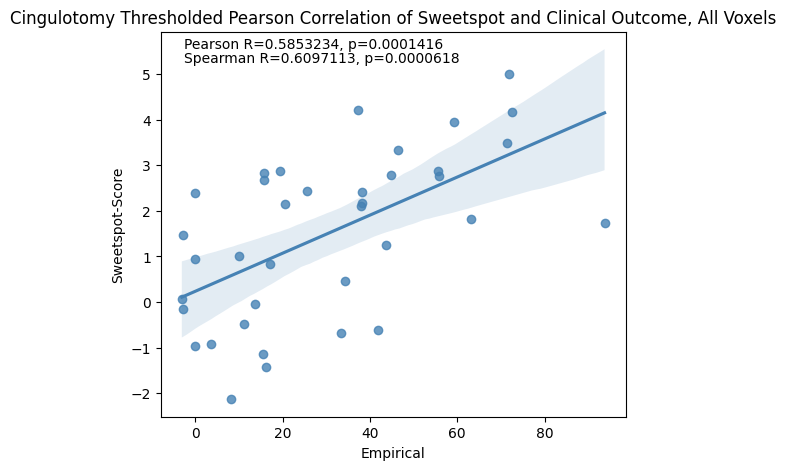

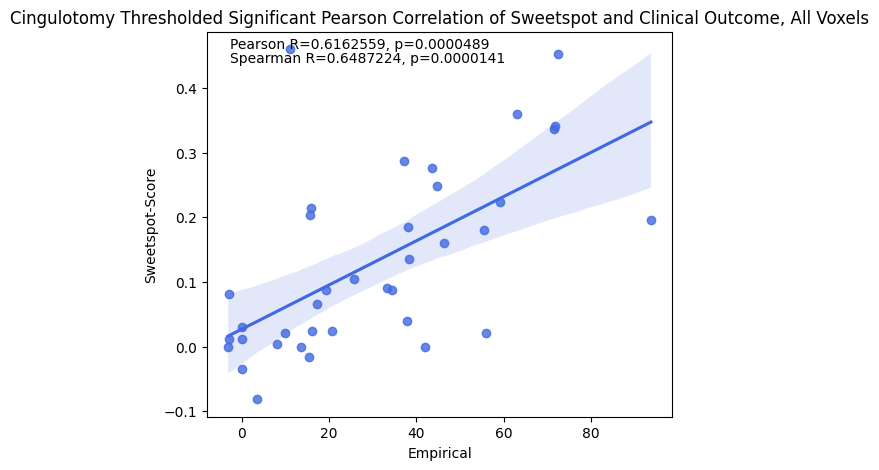

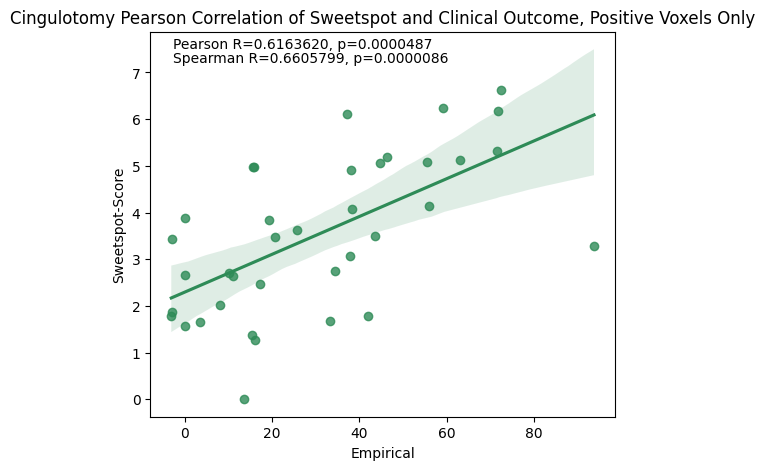

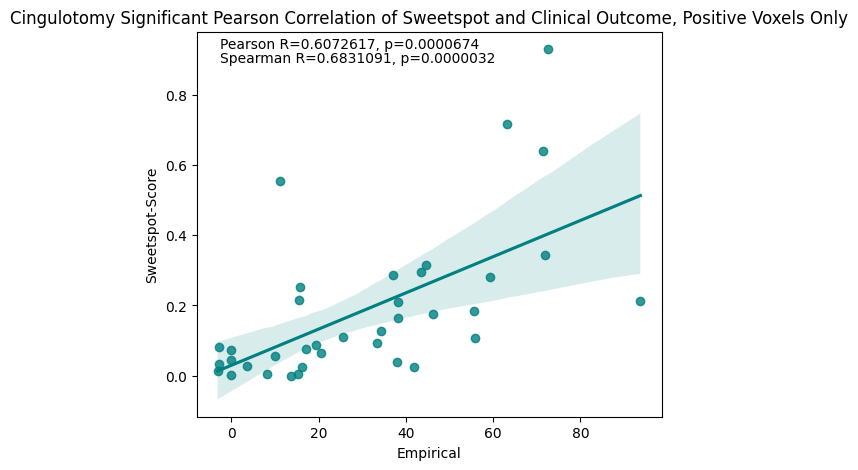

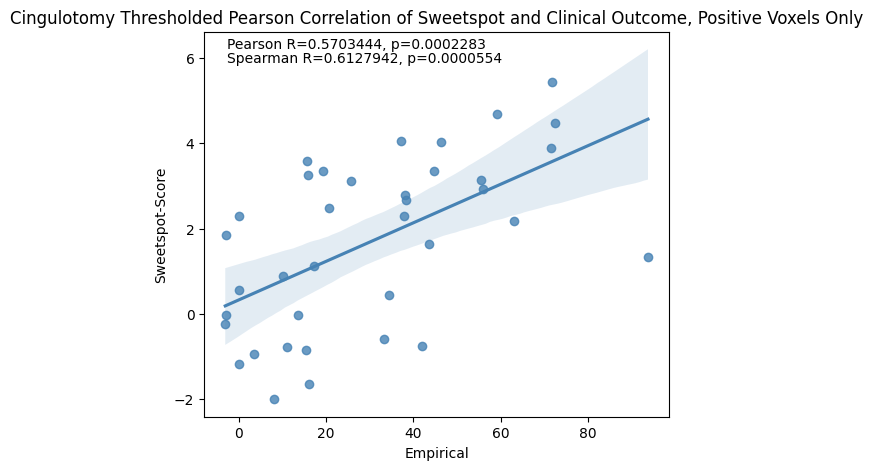

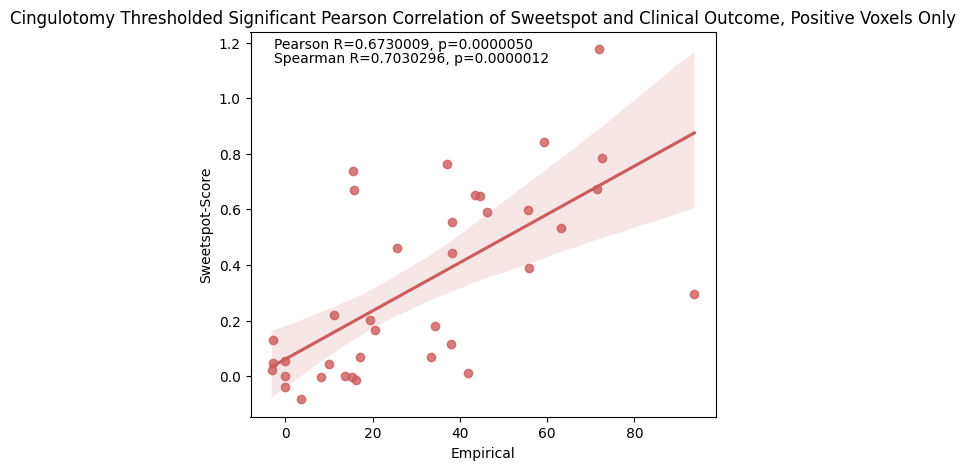

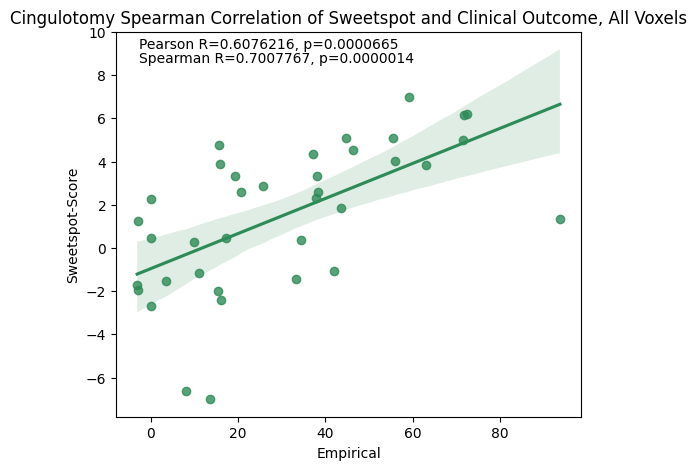

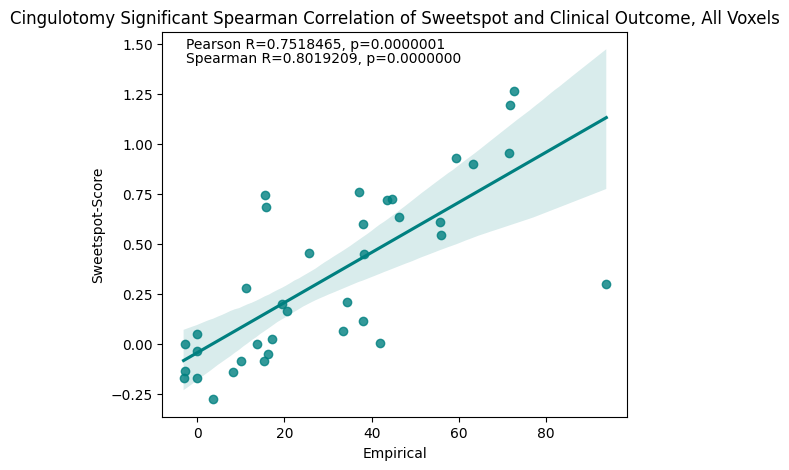

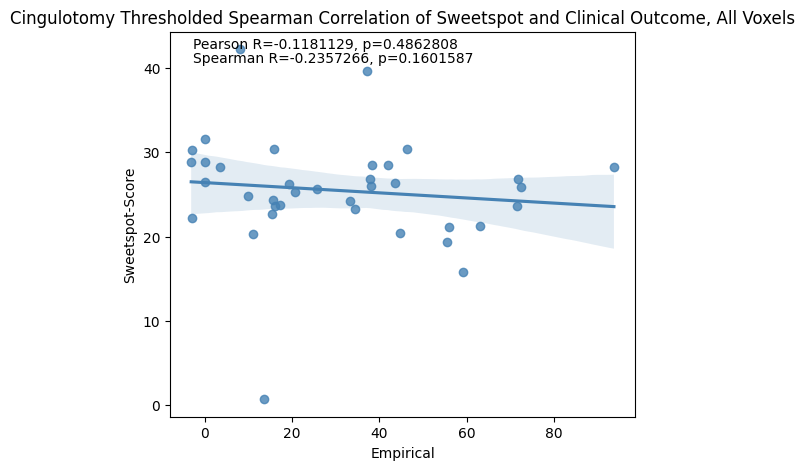

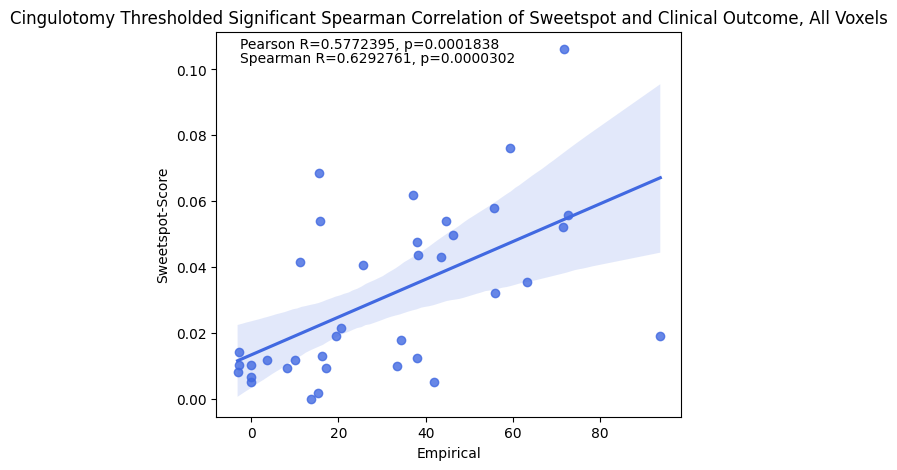

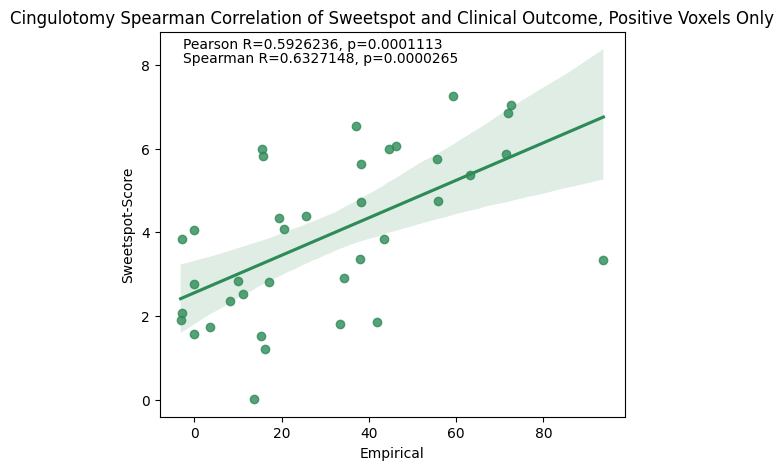

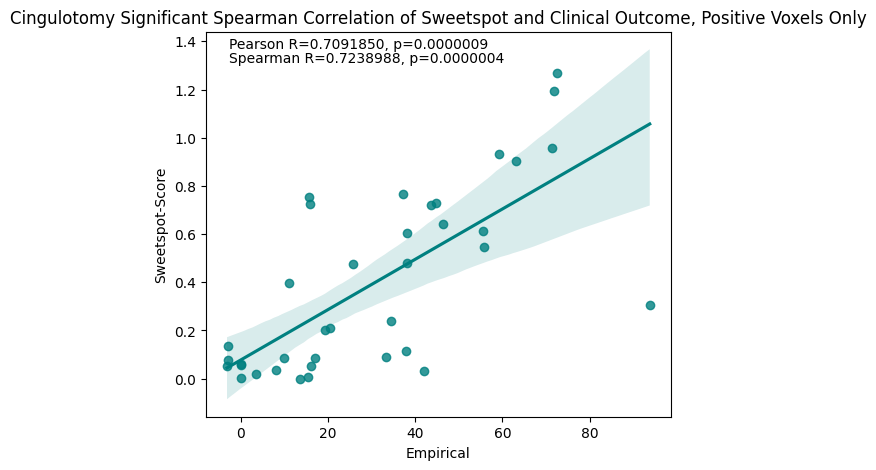

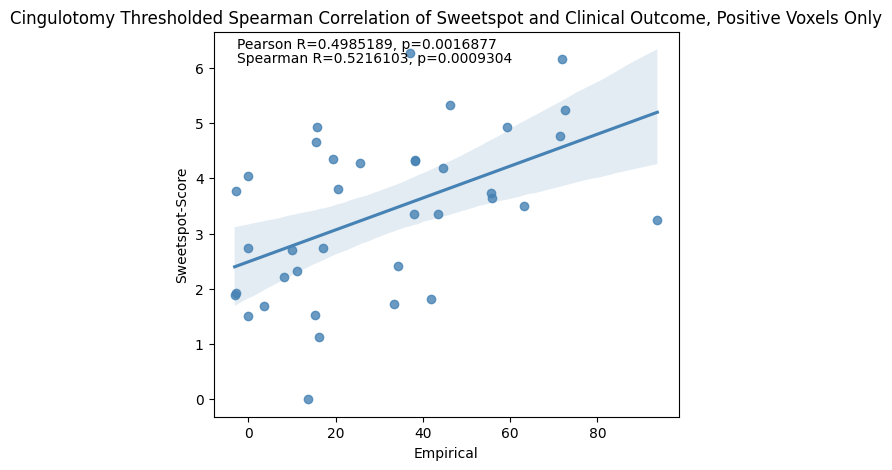

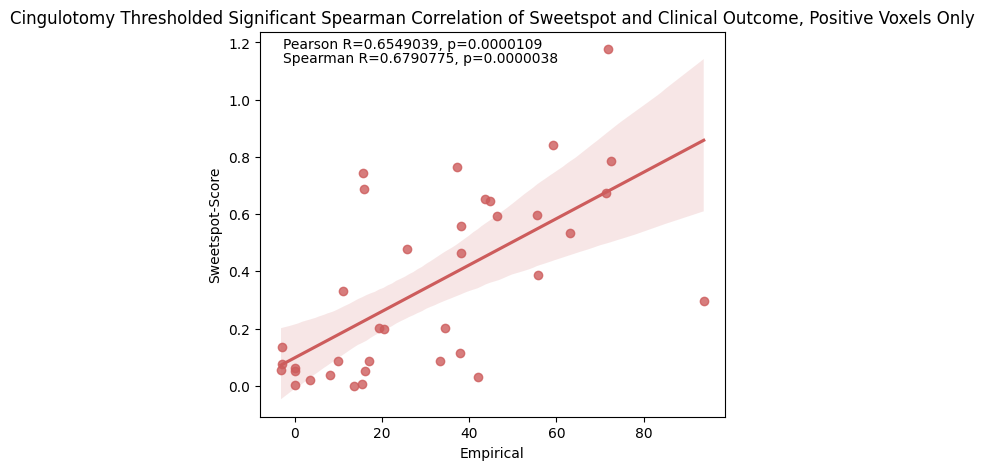

In [8]:
#cingulotomies, relative
def plot_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.show()

#pearson analysis
plot_analysis(cingulotomy_df, pearson_sweetspot_score, 'Cingulotomy Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels', pearson_r_val, pearson_p_val, s_pearson_r_val, s_pearson_p_val, 'seagreen')
plot_analysis(cingulotomy_df, sig_pearson_sweetspot_score, 'Cingulotomy Significant Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',sig_pearson_r_val, sig_pearson_p_val, s_sig_pearson_r_val, s_sig_pearson_p_val, 'teal')
plot_analysis(cingulotomy_df, thresholded_pearson_sweetspot_score, 'Cingulotomy Thresholded Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_pearson_r_val, thresholded_pearson_p_val, s_thresholded_pearson_r_val, s_thresholded_pearson_p_val, 'steelblue')
plot_analysis(cingulotomy_df, thresholded_sig_pearson_sweetspot_score, 'Cingulotomy Thresholded Significant Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_sig_pearson_r_val, thresholded_sig_pearson_p_val, s_thresholded_sig_pearson_r_val, s_thresholded_sig_pearson_p_val, 'royalblue')

#pearson positive voxels only
plot_analysis(cingulotomy_df, pos_pearson_sweetspot_score, 'Cingulotomy Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', pos_pearson_r_val, pos_pearson_p_val, pos_s_pearson_r_val, pos_s_pearson_p_val, 'seagreen')
plot_analysis(cingulotomy_df, pos_sig_pearson_sweetspot_score, 'Cingulotomy Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_sig_pearson_r_val, pos_sig_pearson_p_val, pos_s_sig_pearson_r_val, pos_s_sig_pearson_p_val, 'teal')
plot_analysis(cingulotomy_df, pos_thresholded_pearson_sweetspot_score, 'Cingulotomy Thresholded Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_pearson_r_val, pos_thresholded_pearson_p_val, pos_s_thresholded_pearson_r_val, pos_s_thresholded_pearson_p_val, 'steelblue')
plot_analysis(cingulotomy_df, pos_thresholded_sig_pearson_sweetspot_score, 'Cingulotomy Thresholded Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_sig_pearson_r_val, pos_thresholded_sig_pearson_p_val, pos_s_thresholded_sig_pearson_r_val, pos_s_thresholded_sig_pearson_p_val, 'indianred')
    
    
#spearman analysis
plot_analysis(cingulotomy_df, spearman_sweetspot_score, 'Cingulotomy Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels', p_spearman_r_val, p_spearman_p_val,spearman_r_val, spearman_p_val,'seagreen')
plot_analysis(cingulotomy_df, sig_spearman_sweetspot_score, 'Cingulotomy Significant Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',p_sig_spearman_r_val, p_sig_spearman_p_val,sig_spearman_r_val, sig_spearman_p_val, 'teal')
plot_analysis(cingulotomy_df, thresholded_spearman_sweetspot_score, 'Cingulotomy Thresholded Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',p_thresholded_spearman_r_val, p_thresholded_spearman_p_val,thresholded_spearman_r_val, thresholded_spearman_p_val,'steelblue')
plot_analysis(cingulotomy_df, thresholded_sig_spearman_sweetspot_score, 'Cingulotomy Thresholded Significant Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',p_thresholded_sig_spearman_r_val, p_thresholded_sig_spearman_p_val,thresholded_sig_spearman_r_val, thresholded_sig_spearman_p_val, 'royalblue')

#spearman positive voxels only
plot_analysis(cingulotomy_df, pos_spearman_sweetspot_score, 'Cingulotomy Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', pos_p_spearman_r_val, pos_p_spearman_p_val,pos_spearman_r_val, pos_spearman_p_val,'seagreen')
plot_analysis(cingulotomy_df, pos_sig_spearman_sweetspot_score, 'Cingulotomy Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_p_sig_spearman_r_val, pos_p_sig_spearman_p_val,pos_sig_spearman_r_val, pos_sig_spearman_p_val,'teal')
plot_analysis(cingulotomy_df, pos_thresholded_spearman_sweetspot_score, 'Cingulotomy Thresholded Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_p_thresholded_spearman_r_val, pos_p_thresholded_spearman_p_val,pos_thresholded_spearman_r_val, pos_thresholded_spearman_p_val,'steelblue')
plot_analysis(cingulotomy_df, pos_thresholded_sig_spearman_sweetspot_score, 'Cingulotomy Thresholded Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_p_thresholded_sig_spearman_r_val, pos_p_thresholded_sig_spearman_p_val,pos_thresholded_sig_spearman_r_val, pos_thresholded_sig_spearman_p_val, 'indianred')

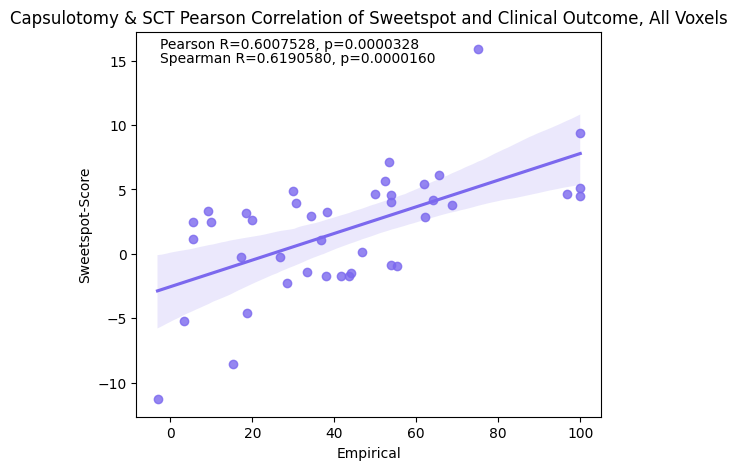

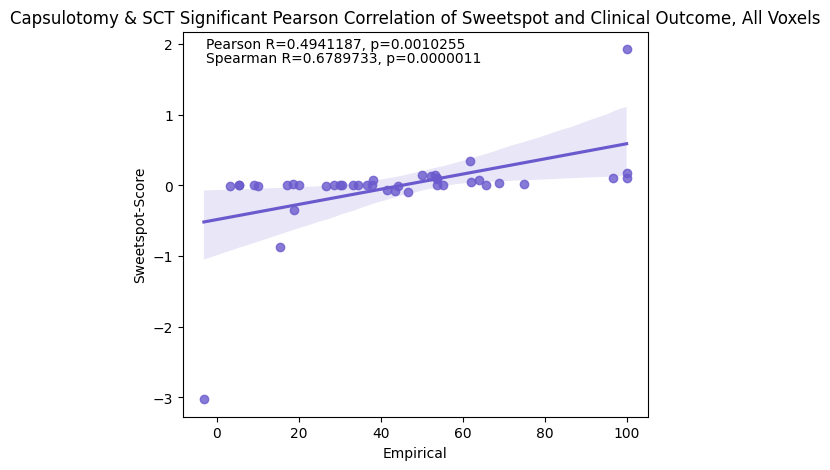

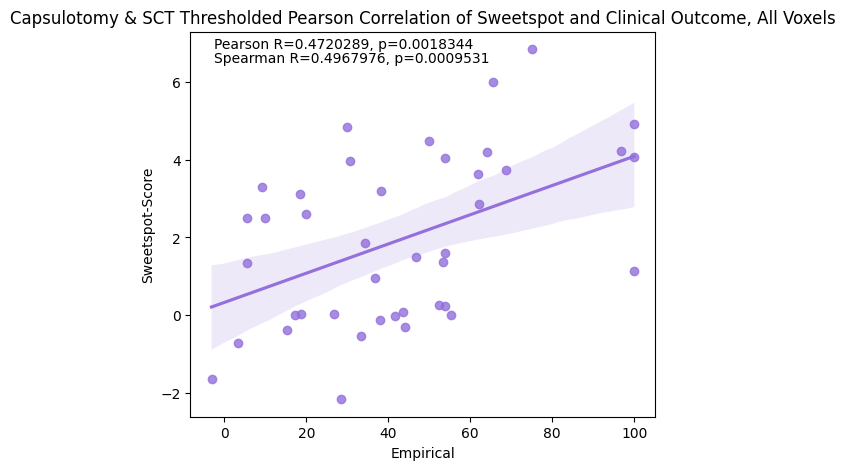

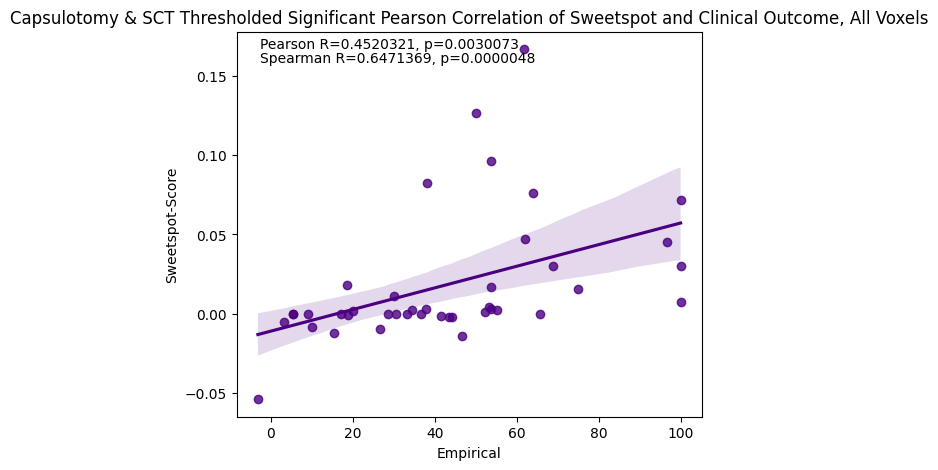

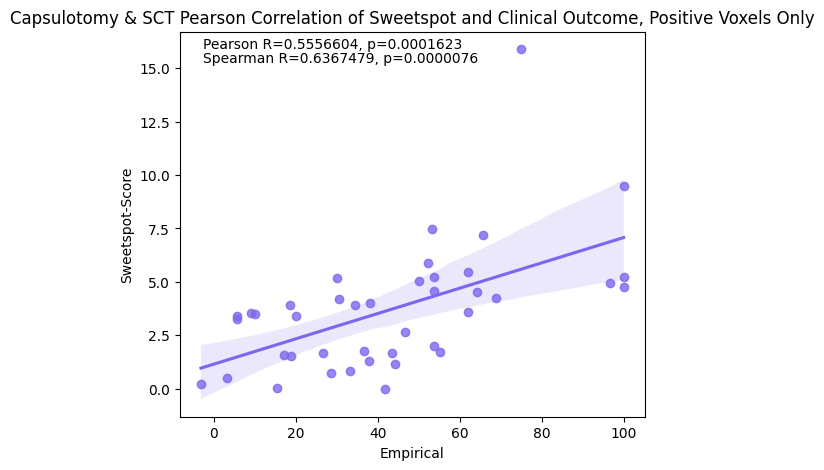

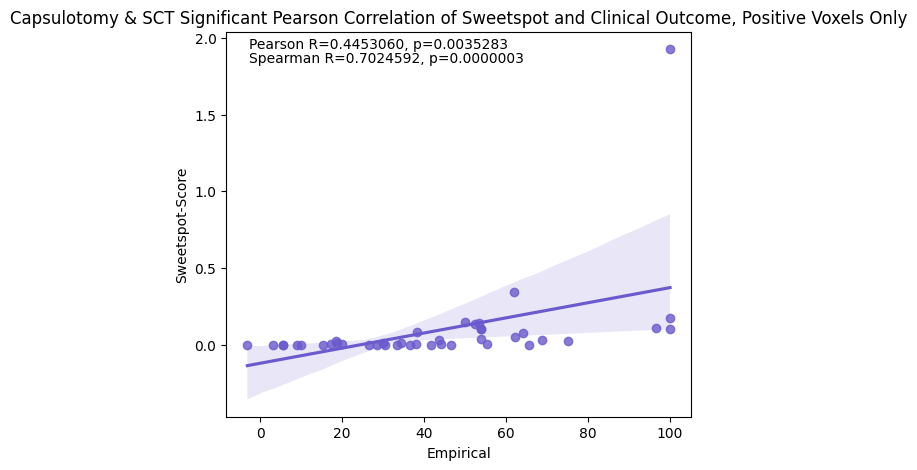

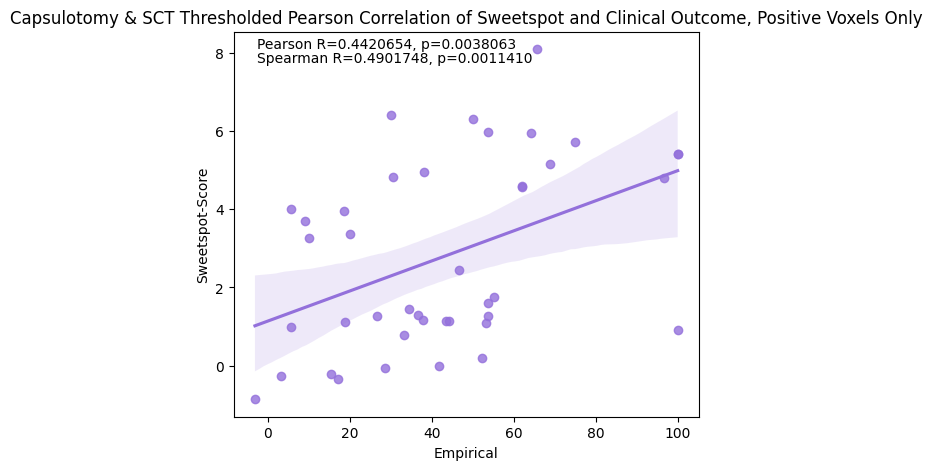

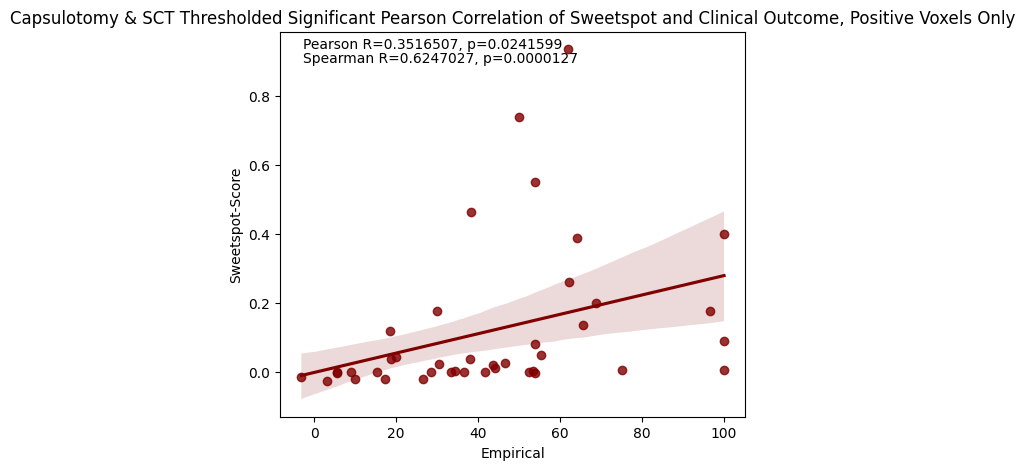

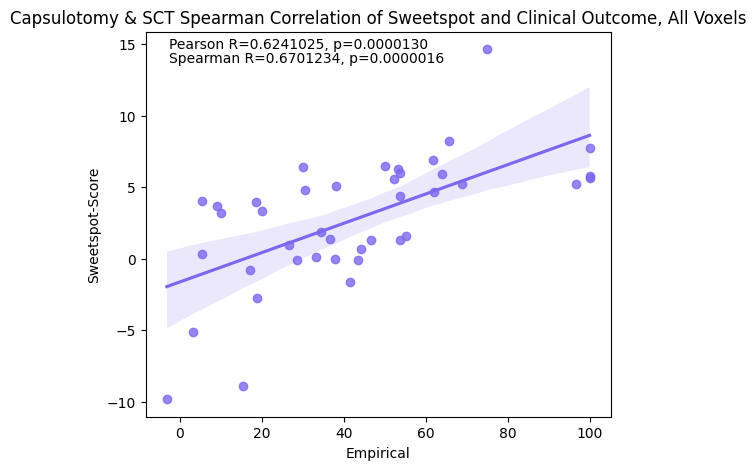

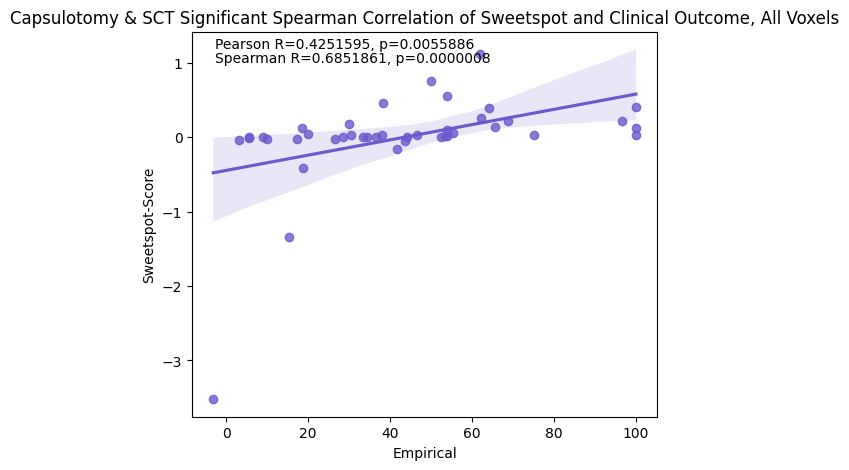

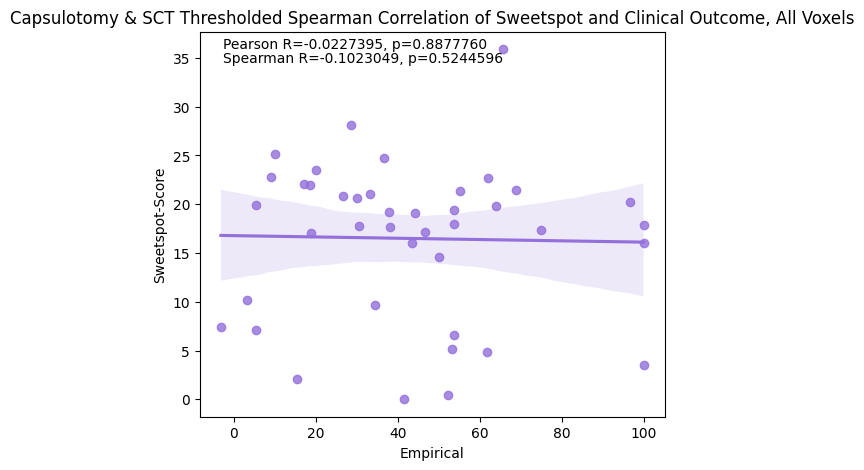

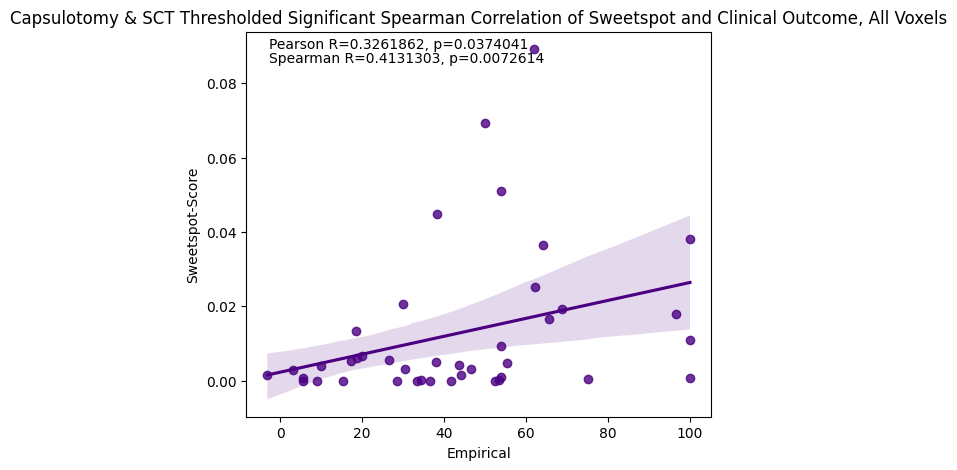

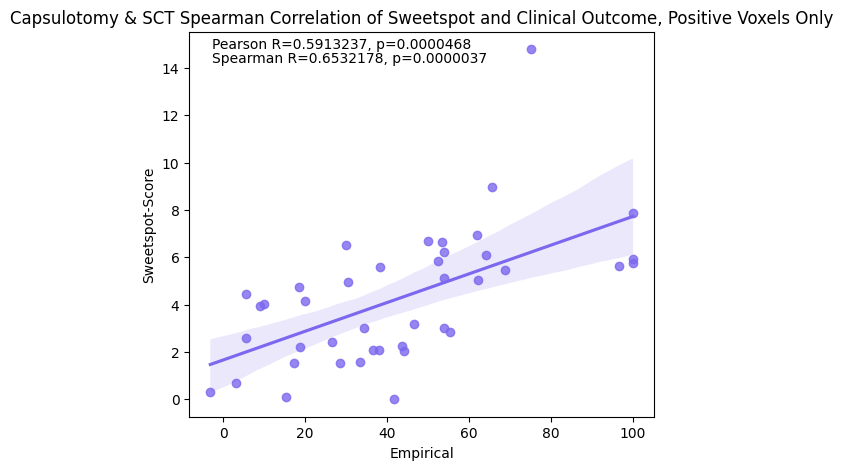

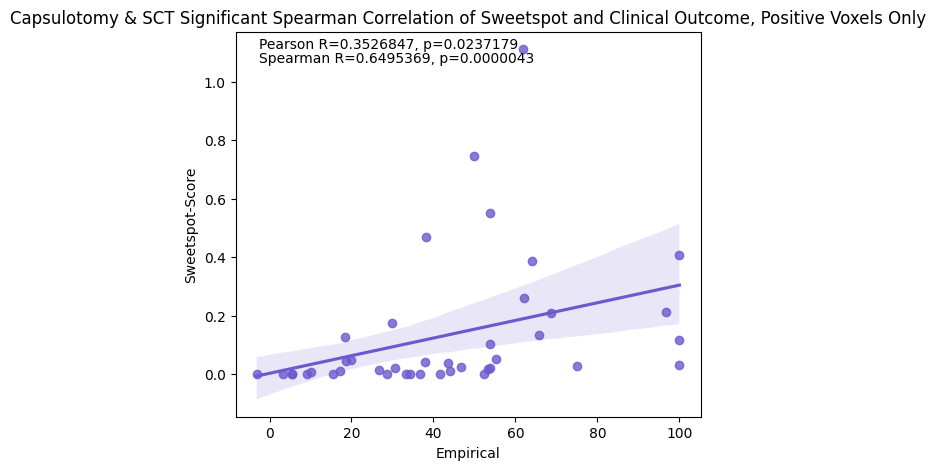

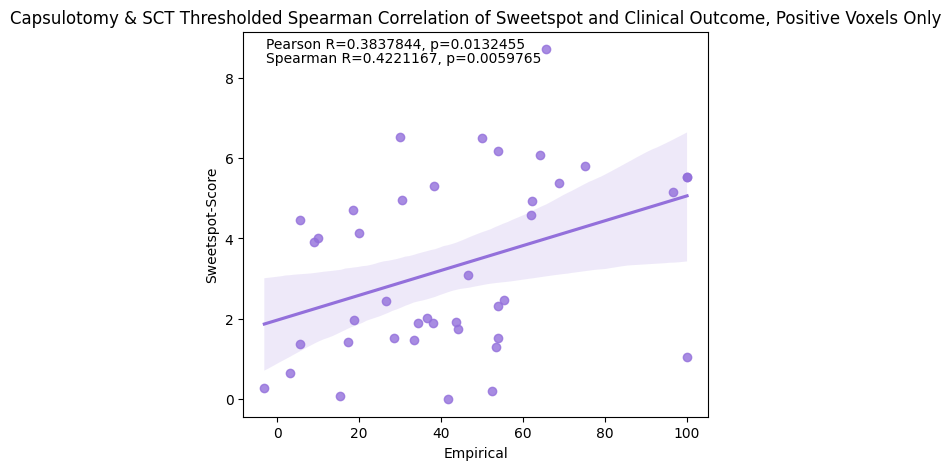

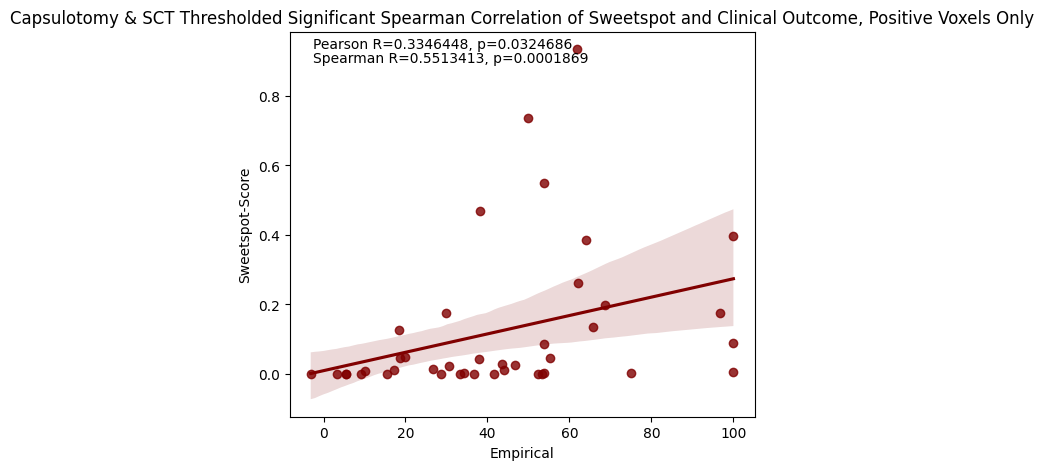

In [6]:
#capsulotomies and scts, relative
def plot_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.show()

#pearson analysis
plot_analysis(cap_sct_df, pearson_sweetspot_score, 'Capsulotomy & SCT Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels', pearson_r_val, pearson_p_val, s_pearson_r_val, s_pearson_p_val, 'mediumslateblue')
plot_analysis(cap_sct_df, sig_pearson_sweetspot_score, 'Capsulotomy & SCT Significant Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',sig_pearson_r_val, sig_pearson_p_val, s_sig_pearson_r_val, s_sig_pearson_p_val, 'slateblue')
plot_analysis(cap_sct_df, thresholded_pearson_sweetspot_score, 'Capsulotomy & SCT Thresholded Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_pearson_r_val, thresholded_pearson_p_val, s_thresholded_pearson_r_val, s_thresholded_pearson_p_val, 'mediumpurple')
plot_analysis(cap_sct_df, thresholded_sig_pearson_sweetspot_score, 'Capsulotomy & SCT Thresholded Significant Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_sig_pearson_r_val, thresholded_sig_pearson_p_val, s_thresholded_sig_pearson_r_val, s_thresholded_sig_pearson_p_val, 'indigo')

#positive
plot_analysis(cap_sct_df, pos_pearson_sweetspot_score, 'Capsulotomy & SCT Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', pos_pearson_r_val, pos_pearson_p_val, pos_s_pearson_r_val, pos_s_pearson_p_val, 'mediumslateblue')
plot_analysis(cap_sct_df, pos_sig_pearson_sweetspot_score, 'Capsulotomy & SCT Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_sig_pearson_r_val, pos_sig_pearson_p_val, pos_s_sig_pearson_r_val, pos_s_sig_pearson_p_val, 'slateblue')
plot_analysis(cap_sct_df, pos_thresholded_pearson_sweetspot_score, 'Capsulotomy & SCT Thresholded Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_pearson_r_val, pos_thresholded_pearson_p_val, pos_s_thresholded_pearson_r_val, pos_s_thresholded_pearson_p_val, 'mediumpurple')
plot_analysis(cap_sct_df, pos_thresholded_sig_pearson_sweetspot_score, 'Capsulotomy & SCT Thresholded Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_sig_pearson_r_val, pos_thresholded_sig_pearson_p_val, pos_s_thresholded_sig_pearson_r_val, pos_s_thresholded_sig_pearson_p_val, 'maroon')

#spearman analysis
plot_analysis(cap_sct_df, spearman_sweetspot_score, 'Capsulotomy & SCT Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',p_spearman_r_val, p_spearman_p_val,spearman_r_val, spearman_p_val,'mediumslateblue')
plot_analysis(cap_sct_df, sig_spearman_sweetspot_score, 'Capsulotomy & SCT Significant Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',p_sig_spearman_r_val, p_sig_spearman_p_val,sig_spearman_r_val, sig_spearman_p_val, 'slateblue')
plot_analysis(cap_sct_df, thresholded_spearman_sweetspot_score, 'Capsulotomy & SCT Thresholded Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',p_thresholded_spearman_r_val, p_thresholded_spearman_p_val,thresholded_spearman_r_val, thresholded_spearman_p_val, 'mediumpurple')
plot_analysis(cap_sct_df, thresholded_sig_spearman_sweetspot_score, 'Capsulotomy & SCT Thresholded Significant Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',p_thresholded_sig_spearman_r_val, p_thresholded_sig_spearman_p_val,thresholded_sig_spearman_r_val, thresholded_sig_spearman_p_val, 'indigo')

#positive voxels only
plot_analysis(cap_sct_df, pos_spearman_sweetspot_score, 'Capsulotomy & SCT Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', pos_p_spearman_r_val, pos_p_spearman_p_val,pos_spearman_r_val, pos_spearman_p_val, 'mediumslateblue')
plot_analysis(cap_sct_df, pos_sig_spearman_sweetspot_score, 'Capsulotomy & SCT Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_p_sig_spearman_r_val, pos_p_sig_spearman_p_val,pos_sig_spearman_r_val, pos_sig_spearman_p_val, 'slateblue')
plot_analysis(cap_sct_df, pos_thresholded_spearman_sweetspot_score, 'Capsulotomy & SCT Thresholded Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_p_thresholded_spearman_r_val, pos_p_thresholded_spearman_p_val,pos_thresholded_spearman_r_val, pos_thresholded_spearman_p_val, 'mediumpurple')
plot_analysis(cap_sct_df, pos_thresholded_sig_spearman_sweetspot_score, 'Capsulotomy & SCT Thresholded Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_p_thresholded_sig_spearman_r_val, pos_p_thresholded_sig_spearman_p_val,pos_thresholded_sig_spearman_r_val, pos_thresholded_sig_spearman_p_val, 'maroon')